In [ ]:
#!pip install SciencePlots

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import openml
import scienceplots

#plt.style.use('ggplot')
plt.style.use(['science', 'ieee', 'no-latex'])

#random_state
rs = 321

# Trabalho de Aprendizagem de Máquina II (PES Embraer)
Alunos: Caio Costa e Jonas Rodrigues

**Do Classroom:**

Seguem algumas instruções para realizar os experimentos:

- selecionar um banco de dados do OpenML (https://www.openml.org/)
    - o banco de dados de classificação deve ter: > 3 classes, >10 atributos e >1000 instâncias
- 10-fold cross-validation
- avaliar máquinas de aprendizagem: kNN, DT, MLP, NB e SVM
- métricas (area under the ROC curve, f1-score, accuracy, matriz de confusão média)
- opcional: para ajustar os parâmetros das máquinas de aprendizagem usar grid-search ou escolher os parâmetros e justificar
- avaliar estratégias de seleção de instâncias, seleção de atributos e/ou de balanceamento  

O relatório final deve conter pelo menos as seguintes informações:
1. Introdução  
2. Conceitos básicos  
    2.1. Técnicas de pré-processamento  
    2.2. Algoritmos de Aprendizagem de Máquina  
3. Metodologia dos Experimentos  
    3.1.Banco de dados  
    3.2.Métricas  
4. Resultados  
5. Conclusões  
6. Referências  

In [2]:
data = openml\
        .datasets\
        .get_dataset(46, download_data=True, download_qualities=True, download_features_meta_data=True)

df = data.get_data()[0]

In [3]:
data

OpenML Dataset
Name..........: splice
Version.......: 1
Format........: ARFF
Upload Date...: 2014-04-06 23:22:49
Licence.......: Public
Download URL..: https://api.openml.org/data/v1/download/46/splice.arff
OpenML URL....: https://www.openml.org/d/46
# of features.: 61
# of instances: 3190

In [4]:
df.head()

,attribute_1,attribute_2,attribute_3,attribute_4,attribute_5,attribute_6,attribute_7,attribute_8,attribute_9,attribute_10,...,attribute_52,attribute_53,attribute_54,attribute_55,attribute_56,attribute_57,attribute_58,attribute_59,attribute_60,Class
0,C,C,A,G,C,T,G,C,A,T,...,G,C,C,A,G,T,C,T,G,EI
1,A,G,A,C,C,C,G,C,C,G,...,T,G,C,C,C,C,C,G,C,EI
2,G,A,G,G,T,G,A,A,G,G,...,A,C,G,G,G,G,A,T,G,EI
3,G,G,G,C,T,G,C,G,T,T,...,G,T,T,T,T,C,C,C,C,EI
4,G,C,T,C,A,G,C,C,C,C,...,C,T,T,G,A,C,C,C,T,EI


In [5]:
#contagem das bases
cols = df.iloc[:,:-1]
cols.melt()['value'].value_counts()

value
C    50300
G    50245
T    46308
A    44487
N       56
D        2
R        1
S        1
Name: count, dtype: int64

In [6]:
#verificação de quantas instâncias possuem as bases ambíguas (N, D, R, S)

#instâncias que contém N, D, R ou S entre as features
idx_ndrs = df.iloc[:,:-1]\
             .isin(["N", "D", "R", "S"])\
             .any(axis=1) 

print(f"Existem {len(df[idx_ndrs])} linhas com bases ambíguas (N, D, R ou S).")

Existem 15 linhas com bases ambíguas (N, D, R ou S).


# Avaliação das classes target

In [7]:
df['Class'].value_counts()

Class
N     1655
IE     768
EI     767
Name: count, dtype: int64

<Axes: >

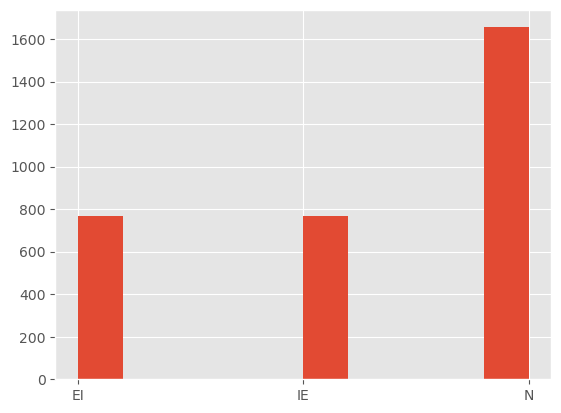

In [8]:
df['Class'].hist()

# Preparo do dataset

In [9]:
#remoção das instâncias com bases ambíguas

df = df[~idx_ndrs]

In [10]:
#converter colunas para categorical
for col in df.columns:
    df[col] = df[col].cat.remove_unused_categories()

# Encoding das features e targets

In [11]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

F = df.columns[:-1]
T = df.columns[-1]

ct = ColumnTransformer([
    ('ohe', OneHotEncoder(), F),
    ('oe', OrdinalEncoder(), [T]) #para este caso, LabelEncoder == OrdinalEncoder
])

In [12]:
encoded = ct.fit_transform(df).toarray()
encoded

array([[0., 1., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 2.],
       [1., 0., 0., ..., 0., 0., 2.],
       [1., 0., 0., ..., 0., 1., 2.]])

# Técnicas de pré-processamento
Nesta seção, criaremos as funções que pré-processam o dataset, para que possamos utilizar mais facilmente com GridSearchCV posteriormente.

In [13]:
#função para imprimir mudanças no tamanho do dataset

def size_diff(X_old, X_new):
    m_new, n_new = X_new.shape
    m_old, n_old = X_old.shape
    m_var = 100*(m_new - m_old)/m_old
    n_var = 100*(n_new - n_old)/n_old
    
    ans = "# Linhas: {} -> {} ({:.0f}%)\n# Colunas: {} -> {} ({:.0f}%)"\
          .format(m_old, m_new, m_var,
                  n_old, n_new, n_var)
    
    return ans

## Balanceamento de classes

### Undersampling da classe majoritária

In [14]:
from imblearn.under_sampling import RandomUnderSampler

def bal_undersampling(X_train, X_test, y_train, y_test):
    rus = RandomUnderSampler(random_state=rs)
    X_res, y_res = rus.fit_resample(X_train, y_train)
    return X_res, X_test, y_res, y_test    

### Synthetic Minority Oversampling Technique (SMOTE)

In [15]:
from imblearn.over_sampling import SMOTE

def bal_smote(X_train, X_test, y_train, y_test):
    smt = SMOTE(random_state=rs)
    X_smt, y_smt = smt.fit_resample(X_train, y_train)
    return X_smt, X_test, y_smt, y_test

## Redução de dimensionalidade

### Principal Component Analysis (PCA)

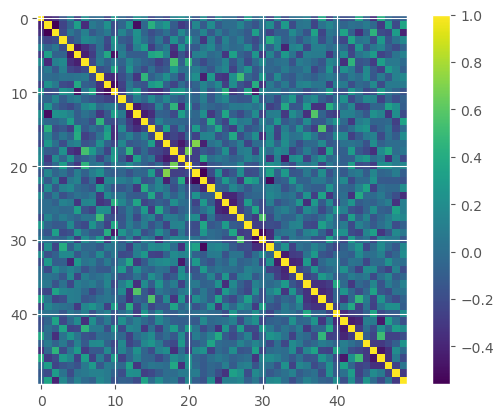

In [16]:
#PCA funciona melhor quando existem muitos atributos correlacionados

plt.imshow(np.corrcoef(encoded[:50, :50], rowvar=False))
plt.colorbar()

In [17]:
from sklearn.decomposition import PCA

def dr_pca(X_train, X_test, y_train, y_test, var=0.90):
    
    #a implementação do sklearn permite definir o número de componentes indiretamente
    #isto é, permite escolher o mínimo de variância que as componentes principais devem explicar
    
    pca = PCA(n_components = var)
    pca.fit(X_train)
    X_train_res = pca.transform(X_train)
    X_test_res = pca.transform(X_test)
    
    return X_train_res, X_test_res, y_train, y_test

**Observação:** Não usaremos Linear Discriminant Analysis (LDA) pois existem somente três classes no dataset, e por isso o número máximo de dimensões geradas seria somente $c-1 = 2$, uma redução muito acentuada com relação aos 240 atributos iniciais.

## Seleção de atributos
Usaremos os métodos de seleção de atributos Chi-Squared e Mutual Information por serem mais apropriados para variáveis de entrada e saída do tipo categórica.

### Chi-squared

In [18]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

def as_chi2(X_train, X_test, y_train, y_test, k=150, return_model=False):
    
    fs = SelectKBest(score_func=chi2, k=k)
    fs.fit(X_train, y_train)
    
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    
    if(return_model):
        return X_train_fs, X_test_fs, y_train, y_test, fs
    
    return X_train_fs, X_test_fs, y_train, y_test

### Mutual information

In [19]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif

def as_mutual_info(X_train, X_test, y_train, y_test, k=150, return_model=False):
    
    fs = SelectKBest(score_func=mutual_info_classif, k=k)
    fs.fit(X_train, y_train)
    
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    
    if(return_model):
        return X_train_fs, X_test_fs, y_train, y_test, fs
    
    return X_train_fs, X_test_fs, y_train, y_test

## Seleção de instâncias

### Edited Nearest Neighbors (ENN)

In [20]:
from imblearn.under_sampling import EditedNearestNeighbours

def ps_enn(X_train, X_test, y_train, y_test, n_neighbors=3):
    enn = EditedNearestNeighbours(n_neighbors=n_neighbors)
    X_res, y_res = enn.fit_resample(X_train, y_train)
    return X_res, X_test, y_res, y_test

### Condensed Nearest Neighbors (CNN)

In [21]:
from imblearn.under_sampling import CondensedNearestNeighbour

def ps_cnn(X_train, X_test, y_train, y_test, n_neighbors=3):
    cnn = CondensedNearestNeighbour(n_neighbors=n_neighbors)
    X_res, y_res = cnn.fit_resample(X_train, y_train)
    return X_res, X_test, y_res, y_test

# Divisão treino-teste
80% treino, 20% teste

In [22]:
from sklearn.model_selection import train_test_split

X = encoded[:, :-1]
y = encoded[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rs)

print(f'X shape: ')
print(f'    Train = {X_train.shape}')
print(f'    Train = {X_test.shape}')
print(f'y shape: ')
print(f'    Train = {y_train.shape}')
print(f'    Test = {y_test.shape}')

X shape: 
    Train = (2540, 240)
    Train = (635, 240)
y shape: 
    Train = (2540,)
    Test = (635,)


Como vimos na análise anterior, nossa base de dados não é demasiadamente desbalanceada. Então optamos por não estratificar nesse caso.

In [23]:
pd.Series(y_train).value_counts(normalize=True)

2.0    0.516929
1.0    0.243307
0.0    0.239764
Name: proportion, dtype: float64

In [24]:
pd.Series(y_test).value_counts(normalize=True)

2.0    0.527559
0.0    0.240945
1.0    0.231496
Name: proportion, dtype: float64

Isso pode ser visto de maneira mais objetiva pelas células acima. É claro que temos uma proporção maior da classe do tipo 2, mas não de forma que acreditamos que seja consideravelmente superior às outras, o que poderia ser um indício de performance ruim dos algoritmos de aprendizado se simplesmente alimentássemos a eles os dados sem demais considerações.

# Preparação dos datasets pré-processados

In [61]:
#order: (X_train, X_test, y_train, y_test)

In [64]:
dataset_labels = ['bal_undersampling', 'bal_smote', 'dr_pca', 'as_chi2', 'as_mutual_info', 'ps_enn', 'ps_cnn']
dataset_pre_proc_funcs = [bal_undersampling, bal_smote, dr_pca, as_chi2, as_mutual_info, ps_enn, ps_cnn]

assert(len(dataset_labels)==len(dataset_pre_proc_funcs))

In [66]:
pp_datasets = {}
pp_datasets['original'] = (X_train, X_test, y_train, y_test)

for key, func in zip(dataset_labels, dataset_pre_proc_funcs):
    pp_datasets[key] = func(X_train, X_test, y_train, y_test)

7it [01:08,  9.78s/it]


In [67]:
for key, value in pp_datasets.items():
    if key != "original":
        print(f"Dimension deltas for {key}:\n{size_diff(X_train, value[0])}\n")

Dimension deltas for bal_undersampling:
# Linhas: 2540 -> 1827 (-28%)
# Colunas: 240 -> 240 (0%)

Dimension deltas for bal_smote:
# Linhas: 2540 -> 3939 (55%)
# Colunas: 240 -> 240 (0%)

Dimension deltas for dr_pca:
# Linhas: 2540 -> 2540 (0%)
# Colunas: 240 -> 145 (-40%)

Dimension deltas for as_chi2:
# Linhas: 2540 -> 2540 (0%)
# Colunas: 240 -> 150 (-38%)

Dimension deltas for as_mutual_info:
# Linhas: 2540 -> 2540 (0%)
# Colunas: 240 -> 150 (-38%)

Dimension deltas for ps_enn:
# Linhas: 2540 -> 1386 (-45%)
# Colunas: 240 -> 240 (0%)

Dimension deltas for ps_cnn:
# Linhas: 2540 -> 1473 (-42%)
# Colunas: 240 -> 240 (0%)



# Classificadores e parâmetros para busca


Nesta seção e nas seguintes, exploraremos os seguintes algoritmos de aprendizado e seus hiperparâmetris:

- kNearest Neighbors (KNN);
- Decision Trees (DT);
- Multi-Layer Perceptron (MLP);
- Naive-Bayes (NB); 
- Support Vector Machines (SVM).

In [30]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC

from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, roc_curve

In [31]:
estimators = {'knn': KNeighborsClassifier(), 
              'dt': DecisionTreeClassifier(),
              'mlp': MLPClassifier(),
              'nb': BernoulliNB(),
              'svm': SVC(probability=True)}

In [32]:
#listagem de hiperparâmetros

for a, b in estimators.items():
    print("Parâmetros padrões para {}: \n{}\n".format(b, b.get_params()))

Parâmetros padrões para KNeighborsClassifier(): 
{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}

Parâmetros padrões para DecisionTreeClassifier(): 
{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}

Parâmetros padrões para MLPClassifier(): 
{'activation': 'relu', 'alpha': 0.0001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_fun': 15000, 'max_iter': 200, 'momentum': 0.9, 'n_iter_no_change': 10, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': None, 'shuffle': True, 'solver': 'adam', 'tol': 0.0001, 'validation

In [33]:
# #parâmetros para busca (grid completa)

# param_grid = {
    
#     'knn': [{
#         'n_neighbors': [5, 7, 9, 11, 13, 15, 17, 19, 20, 30, 40, 50, 60, 70],
#         'weights': ['uniform', 'distance'],
#         'p': [1,2]
#     },
#     {
#         'metric': ['hamming'],
#         'weights': ['uniform', 'distance'],
#         'n_neighbors': [5, 7, 9, 11, 13, 15, 17, 19, 20, 30, 40, 50, 60, 70]
#     }],
    
#     'dt': {
#         'criterion': ["gini", "entropy", 'log_loss'],
#         'splitter': ['best', 'random'],
#         'min_samples_leaf': [1, 2, 3]
#     },
    
#     'mlp': {
#         {
#             'hidden_layer_sizes': [[2], [4], [8], [2, 4, 2], [2, 4, 8, 4, 2]],
#             'activation': ['logistic', 'tanh', 'relu'],
#             'solver': ['lbfgs'],
#             'learning_rate_init': [1e-4, 1e-3, 1e-2, 1e-1],
#             'batch_size': [32, 64, 128, 256]
#         },
#         {
#             'hidden_layer_sizes': [[2], [4], [8], [2, 4, 2], [2, 4, 8, 4, 2]],
#             'activation': ['logistic', 'tanh', 'relu'],
#             'solver': ['adam'],
#             'learning_rate_init': [1e-4, 1e-3, 1e-2, 1e-1],
#             'batch_size': [32, 64, 128, 256],
#             'max_iter': [10, 50, 100, 200, 500]
#         }
#     },
    
#     'nb': {
#         'alpha': [0.001, 0.01, 0.1, 1, 2, 10],
#         'fit_prior': [True, False]
#     },

#     'svm': [{
#         'C': [1, 2, 5, 10],
#         'kernel': ['linear', 'rbf']
#         },
#         {
#         'C': [1, 2, 5, 10],
#         'kernel': ['poly'],
#         'degree': [2, 3]
#     }]

# }


In [34]:
#parâmetros para busca (somente melhores parâmetros para cada estimador - do trabalho anterior)


param_grid = {
    
    'knn': {
        'weights': ['distance'],
        'n_neighbors': [70],
        'p': [1]
    },
    
    'dt': {
        'criterion': ['entropy'],
        'min_samples_leaf': [2],
        'splitter': ['random']
    },
    
    'mlp': {
        'activation': ['logistic'],
        'batch_size': [32],
        'hidden_layer_sizes': [8],
        'learning_rate_init': [0.0001]
    },
    
    'nb': {
        'alpha': [2]
    },

    'svm': {
        'C': [1],
        'kernel': ['poly']
    }

}

# 10-fold stratified cross-validation

In [35]:
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=rs)

# Baseline

In [52]:
from sklearn.dummy import DummyClassifier

dummy_clf_1 = DummyClassifier(strategy="most_frequent", random_state=rs).fit(X_train, y_train)
y_d1 = dummy_clf_1.predict(X_test)

dummy_clf_2 = DummyClassifier(strategy="stratified", random_state=rs).fit(X_train, y_train)
y_d2 = dummy_clf_2.predict(X_test)

In [53]:
print(f"Baseline de acurácia (prever o mais frequente) = {accuracy_score(y_d1, y_test)}")
print(f"Baseline de acurácia (prever aleatoriamente na mesma proporção) = {accuracy_score(y_d2, y_test)}")

Baseline de acurácia (prever o mais frequente) = 0.5275590551181102
Baseline de acurácia (prever aleatoriamente na mesma proporção) = 0.38110236220472443


In [54]:
print(f"Baseline de f1_score (prever o mais frequente) = {f1_score(y_d1, y_test, average='macro')}")
print(f"Baseline de f1_score (prever aleatoriamente na mesma proporção) = {f1_score(y_d2, y_test, average='macro')}")

Baseline de f1_score (prever o mais frequente) = 0.23024054982817868
Baseline de f1_score (prever aleatoriamente na mesma proporção) = 0.3326463258132321


**Não calcularemos uma baseline do score ROC AUC pois a definição é imprecisa para estes classificadores dummy:**
- Para o classificador "most_frequent", todas as predições são da mesma classe (a classe majoritária)
- Para o classificador "stratified", as probabilidades para cada instância são sempre da forma (0, 0, ..., 1, ..., 0, 0, 0), de modo que não faz sentido variar o limiar para calcular os vários pontos da curva ROC, mesmo usando One-vs-One ou One-vs-Rest.

# Grid Search CV

In [39]:
#função para gravar métricas de teste

def log_eval_metrics(actual, pred, pred_proba, prefix='test_'):
    
    f1 = f1_score(actual, pred, average='macro')
    acc = accuracy_score(actual, pred)
    roc_auc = roc_auc_score(actual, pred_proba, multi_class='ovr', average='macro') #'ovr' ou 'ovo'
    
    return f1, acc, roc_auc

In [40]:
from sklearn.metrics import accuracy_score, make_scorer

metrics = {"AUC": make_scorer(roc_auc_score, multi_class='ovo', needs_proba=True),
           "Accuracy": make_scorer(accuracy_score),
           "F1-Score": make_scorer(f1_score, average='macro')}

In [41]:
assert(estimators.keys() == param_grid.keys())

In [42]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from itertools import product

#saídas dos GridSearchs
est_labels = []
dataset_labels = []
best_estimators = []
cv_results_train = []
results_test = []
conf_mats = []

for (est_name, est_est), (ds_name, ds_data) in product(estimators.items(), pp_datasets.items()):
    
    est_labels.append(est_name)
    dataset_labels.append(ds_name)
    
    X_train_, X_test_, y_train_, y_test_ = ds_data
    
    print(f"Executando {est_name} com dataset {ds_name}...")
    
    grid = GridSearchCV(estimator = est_est,
                        param_grid = param_grid[est_name],
                        scoring = metrics,
                        cv = cv,
                        verbose=2,
                        n_jobs=-1,
                        refit="F1-Score")
    
    grid.fit(X_train_, y_train_)
    
    cv_results_train.append(grid.cv_results_)
    best_estimators.append(grid.best_estimator_)
    
    #predição
    y_pred = grid.predict(X_test_)
    y_pred_proba = grid.predict_proba(X_test_)
    
    conf_mats.append(confusion_matrix(y_test_, y_pred))
    
    results_test.append(log_eval_metrics(y_test_, y_pred, y_pred_proba))

Executando knn com dataset original...
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Executando knn com dataset bal_undersampling...
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Executando knn com dataset bal_smote...
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Executando knn com dataset dr_pca...
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Executando knn com dataset as_chi2...
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Executando knn com dataset as_mutual_info...
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Executando knn com dataset ps_enn...
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Executando knn com dataset ps_cnn...
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Executando dt com dataset original...
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Executando dt com dataset bal_undersampling...
Fitting 10 folds for each of 1 candidates, to

C:\Users\Caio\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Executando mlp com dataset bal_undersampling...
Fitting 10 folds for each of 1 candidates, totalling 10 fits


C:\Users\Caio\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Executando mlp com dataset bal_smote...
Fitting 10 folds for each of 1 candidates, totalling 10 fits


C:\Users\Caio\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Executando mlp com dataset dr_pca...
Fitting 10 folds for each of 1 candidates, totalling 10 fits


C:\Users\Caio\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Executando mlp com dataset as_chi2...
Fitting 10 folds for each of 1 candidates, totalling 10 fits


C:\Users\Caio\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Executando mlp com dataset as_mutual_info...
Fitting 10 folds for each of 1 candidates, totalling 10 fits


C:\Users\Caio\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Executando mlp com dataset ps_enn...
Fitting 10 folds for each of 1 candidates, totalling 10 fits


C:\Users\Caio\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Executando mlp com dataset ps_cnn...
Fitting 10 folds for each of 1 candidates, totalling 10 fits


C:\Users\Caio\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Executando nb com dataset original...
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Executando nb com dataset bal_undersampling...
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Executando nb com dataset bal_smote...
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Executando nb com dataset dr_pca...
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Executando nb com dataset as_chi2...
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Executando nb com dataset as_mutual_info...
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Executando nb com dataset ps_enn...
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Executando nb com dataset ps_cnn...
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Executando svm com dataset original...
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Executando svm com dataset bal_undersampling...
Fitting 10 folds for each of 1 candidates, totallin

In [43]:
#funções auxiliares para gerar dataframes com métricas para análises

import re

def generate_train_metrics(table, est_labels, dataset_labels):
    
    assert(len(table)==len(est_labels))
    assert(len(est_labels)==len(dataset_labels))
    
    rt = table.copy()
    
    for i in range(len(rt)):
        rt[i] = pd.DataFrame(rt[i])
        discard_cols = [x for x in rt[i].columns if re.compile(r"param_.*").match(x)]
        rt[i]['estimator_name'] = est_labels[i]
        rt[i]['dataset_name'] = dataset_labels[i]
        
        rt[i] = rt[i].drop(columns=discard_cols)
    
    return pd.concat(rt).reset_index(drop=True)

def generate_test_metrics(table, est_labels, dataset_labels):
    assert(len(table)==len(est_labels))
    assert(len(est_labels)==len(dataset_labels))
    
    ans = pd.DataFrame(table)
    ans.columns = ['f1', 'acc', 'roc_auc']
    
    ans['estimator_name'] = est_labels
    ans['dataset_name'] = dataset_labels
    
    return ans

In [44]:
train_metrics_df = generate_train_metrics(cv_results_train, est_labels, dataset_labels)
train_metrics_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params,split0_test_AUC,split1_test_AUC,split2_test_AUC,split3_test_AUC,split4_test_AUC,...,split5_test_F1-Score,split6_test_F1-Score,split7_test_F1-Score,split8_test_F1-Score,split9_test_F1-Score,mean_test_F1-Score,std_test_F1-Score,rank_test_F1-Score,estimator_name,dataset_name
0,0.005700,0.002101,0.317099,0.002588,"{'n_neighbors': 70, 'p': 1, 'weights': 'distan...",0.990857,0.989136,0.996565,0.979775,0.989954,...,0.897048,0.886026,0.901404,0.873412,0.908179,0.893110,0.021209,1,knn,original
1,0.003604,0.000918,0.150297,0.010170,"{'n_neighbors': 70, 'p': 1, 'weights': 'distan...",0.991355,0.980964,0.985801,0.979038,0.970438,...,0.692327,0.709354,0.756376,0.749569,0.713012,0.710069,0.027369,1,knn,bal_undersampling
2,0.012201,0.003892,0.556199,0.003710,"{'n_neighbors': 70, 'p': 1, 'weights': 'distan...",0.992971,0.995215,0.995125,0.995945,0.991280,...,0.821699,0.846656,0.817208,0.806441,0.827938,0.835339,0.017189,1,knn,bal_smote
3,0.005101,0.001578,0.174099,0.010719,"{'n_neighbors': 70, 'p': 1, 'weights': 'distan...",0.986893,0.983280,0.987284,0.977662,0.983987,...,0.910511,0.883228,0.878541,0.908419,0.929204,0.894795,0.018427,1,knn,dr_pca
4,0.004302,0.001006,0.172697,0.008877,"{'n_neighbors': 70, 'p': 1, 'weights': 'distan...",0.994265,0.989444,0.997158,0.983804,0.987955,...,0.873733,0.845752,0.867068,0.894450,0.874294,0.873218,0.016932,1,knn,as_chi2
5,0.004601,0.000800,0.171498,0.008823,"{'n_neighbors': 70, 'p': 1, 'weights': 'distan...",0.994956,0.991425,0.995531,0.983919,0.991428,...,0.892605,0.884845,0.905634,0.863642,0.901986,0.884867,0.024825,1,knn,as_mutual_info
6,0.002802,0.000601,0.094399,0.008901,"{'n_neighbors': 70, 'p': 1, 'weights': 'distan...",0.996911,0.991686,0.997426,0.994462,0.994812,...,0.731707,0.702987,0.862322,0.755533,0.742979,0.750870,0.041337,1,knn,ps_enn
7,0.003601,0.000801,0.101099,0.004613,"{'n_neighbors': 70, 'p': 1, 'weights': 'distan...",0.973163,0.961466,0.985008,0.971861,0.983779,...,0.696994,0.594888,0.655988,0.676393,0.697575,0.658183,0.032704,1,knn,ps_cnn
8,0.042299,0.005331,0.006500,0.001285,"{'criterion': 'entropy', 'min_samples_leaf': 2...",0.971727,0.950543,0.960038,0.945444,0.934258,...,0.918868,0.934447,0.941940,0.933077,0.942698,0.928083,0.016639,1,dt,original
9,0.027099,0.002546,0.006001,0.000895,"{'criterion': 'entropy', 'min_samples_leaf': 2...",0.947192,0.954604,0.959016,0.933889,0.927103,...,0.939868,0.923545,0.928521,0.917563,0.945152,0.923421,0.016737,1,dt,bal_undersampling


In [45]:
#melhor dataset para cada estimador (f1-score para o conjunto de treino)
idx = train_metrics_df.groupby('estimator_name')['mean_test_F1-Score'].idxmax()
train_metrics_df.iloc[idx, -2:]

,estimator_name,dataset_name
10,dt,bal_smote
3,knn,dr_pca
22,mlp,ps_enn
30,nb,ps_enn
38,svm,ps_enn


In [46]:
#melhor estimador para cada dataset (f1-score para o conjunto de treino)
idx = train_metrics_df.groupby('dataset_name')['mean_test_F1-Score'].idxmax()
train_metrics_df.iloc[idx, -2:].iloc[:, [1,0]]

,dataset_name,estimator_name
36,as_chi2,svm
37,as_mutual_info,svm
34,bal_smote,svm
33,bal_undersampling,svm
19,dr_pca,mlp
32,original,svm
39,ps_cnn,svm
38,ps_enn,svm


In [47]:
#todas as métricas de teste
test_metrics_df = generate_test_metrics(results_test, est_labels, dataset_labels)
test_metrics_df.sort_values('f1', ascending=False)

,f1,acc,roc_auc,estimator_name,dataset_name
37,0.961440,0.965354,0.996010,svm,as_mutual_info
32,0.958730,0.963780,0.996765,svm,original
33,0.958445,0.963780,0.996968,svm,bal_undersampling
36,0.957371,0.963780,0.995696,svm,as_chi2
29,0.956764,0.962205,0.996034,nb,as_mutual_info
34,0.954285,0.960630,0.996792,svm,bal_smote
26,0.954082,0.959055,0.996383,nb,bal_smote
28,0.953381,0.960630,0.995904,nb,as_chi2
25,0.951826,0.959055,0.996057,nb,bal_undersampling
39,0.950078,0.955906,0.996223,svm,ps_cnn


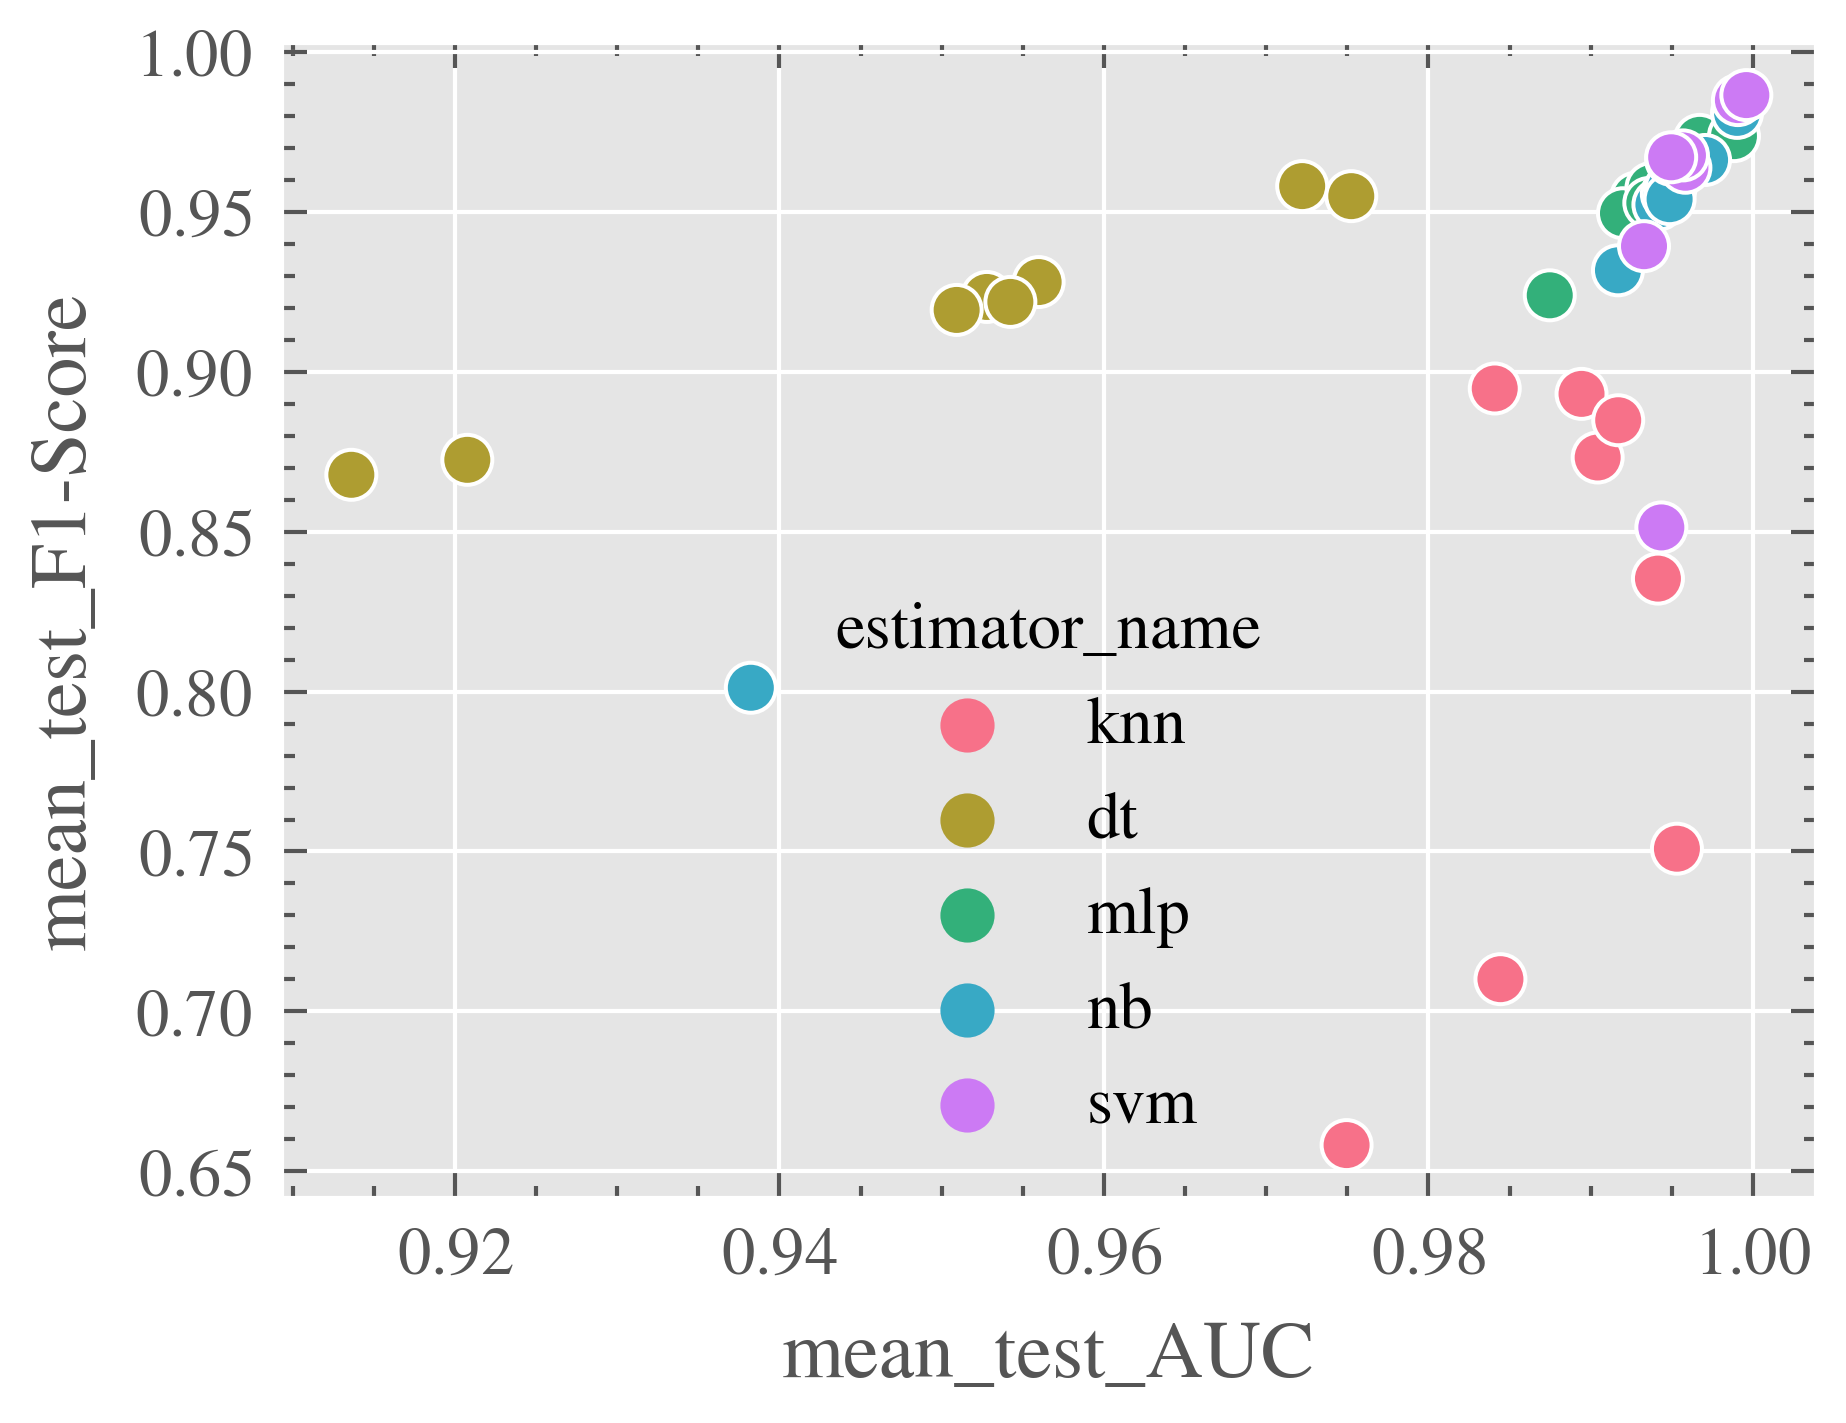

In [130]:
#TO DO: colocar marcadores diferentes para cada estimador
#TO DO: colocar cores diferentes para cada dataset
#TO DO: colocar marcador maior ou menor para dataset original (comparação com trab 1)

sns.scatterplot(x='mean_test_AUC', y='mean_test_F1-Score', data=train_metrics_df, hue='estimator_name')
#plt.title("AUC x F1 Score (treino)")
plt.show()

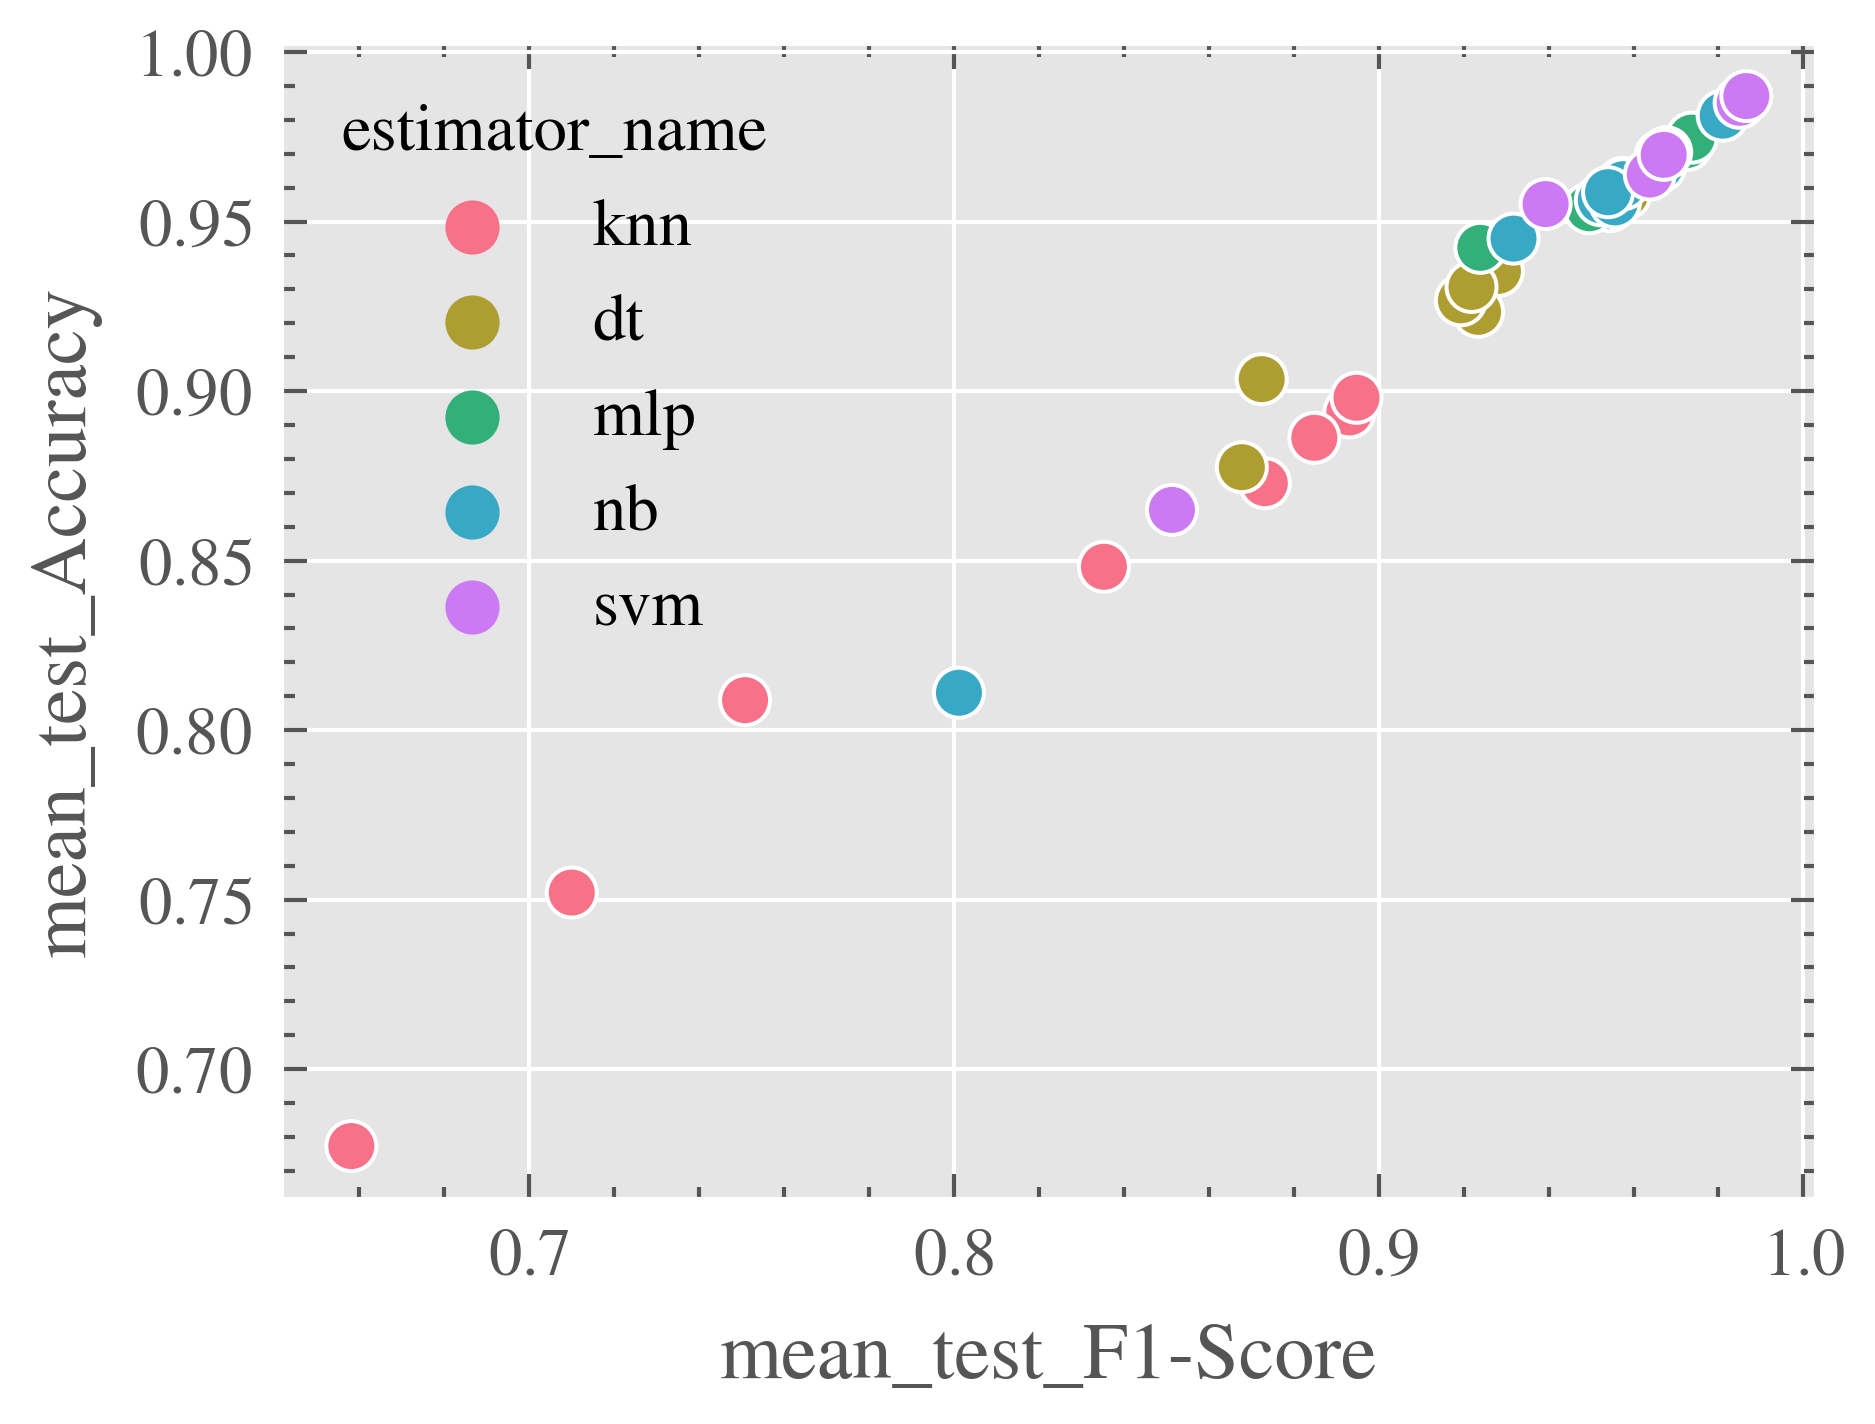

In [139]:
#TO DO: colocar marcadores diferentes para cada estimador
#TO DO: colocar cores diferentes para cada dataset
#TO DO: colocar marcador maior ou menor para dataset original (comparação com trab 1)

sns.scatterplot(x='mean_test_F1-Score', y='mean_test_Accuracy', data=train_metrics_df, hue='estimator_name')
#plt.title("F1 Score x Accuracy (treino)")
plt.show()

[]

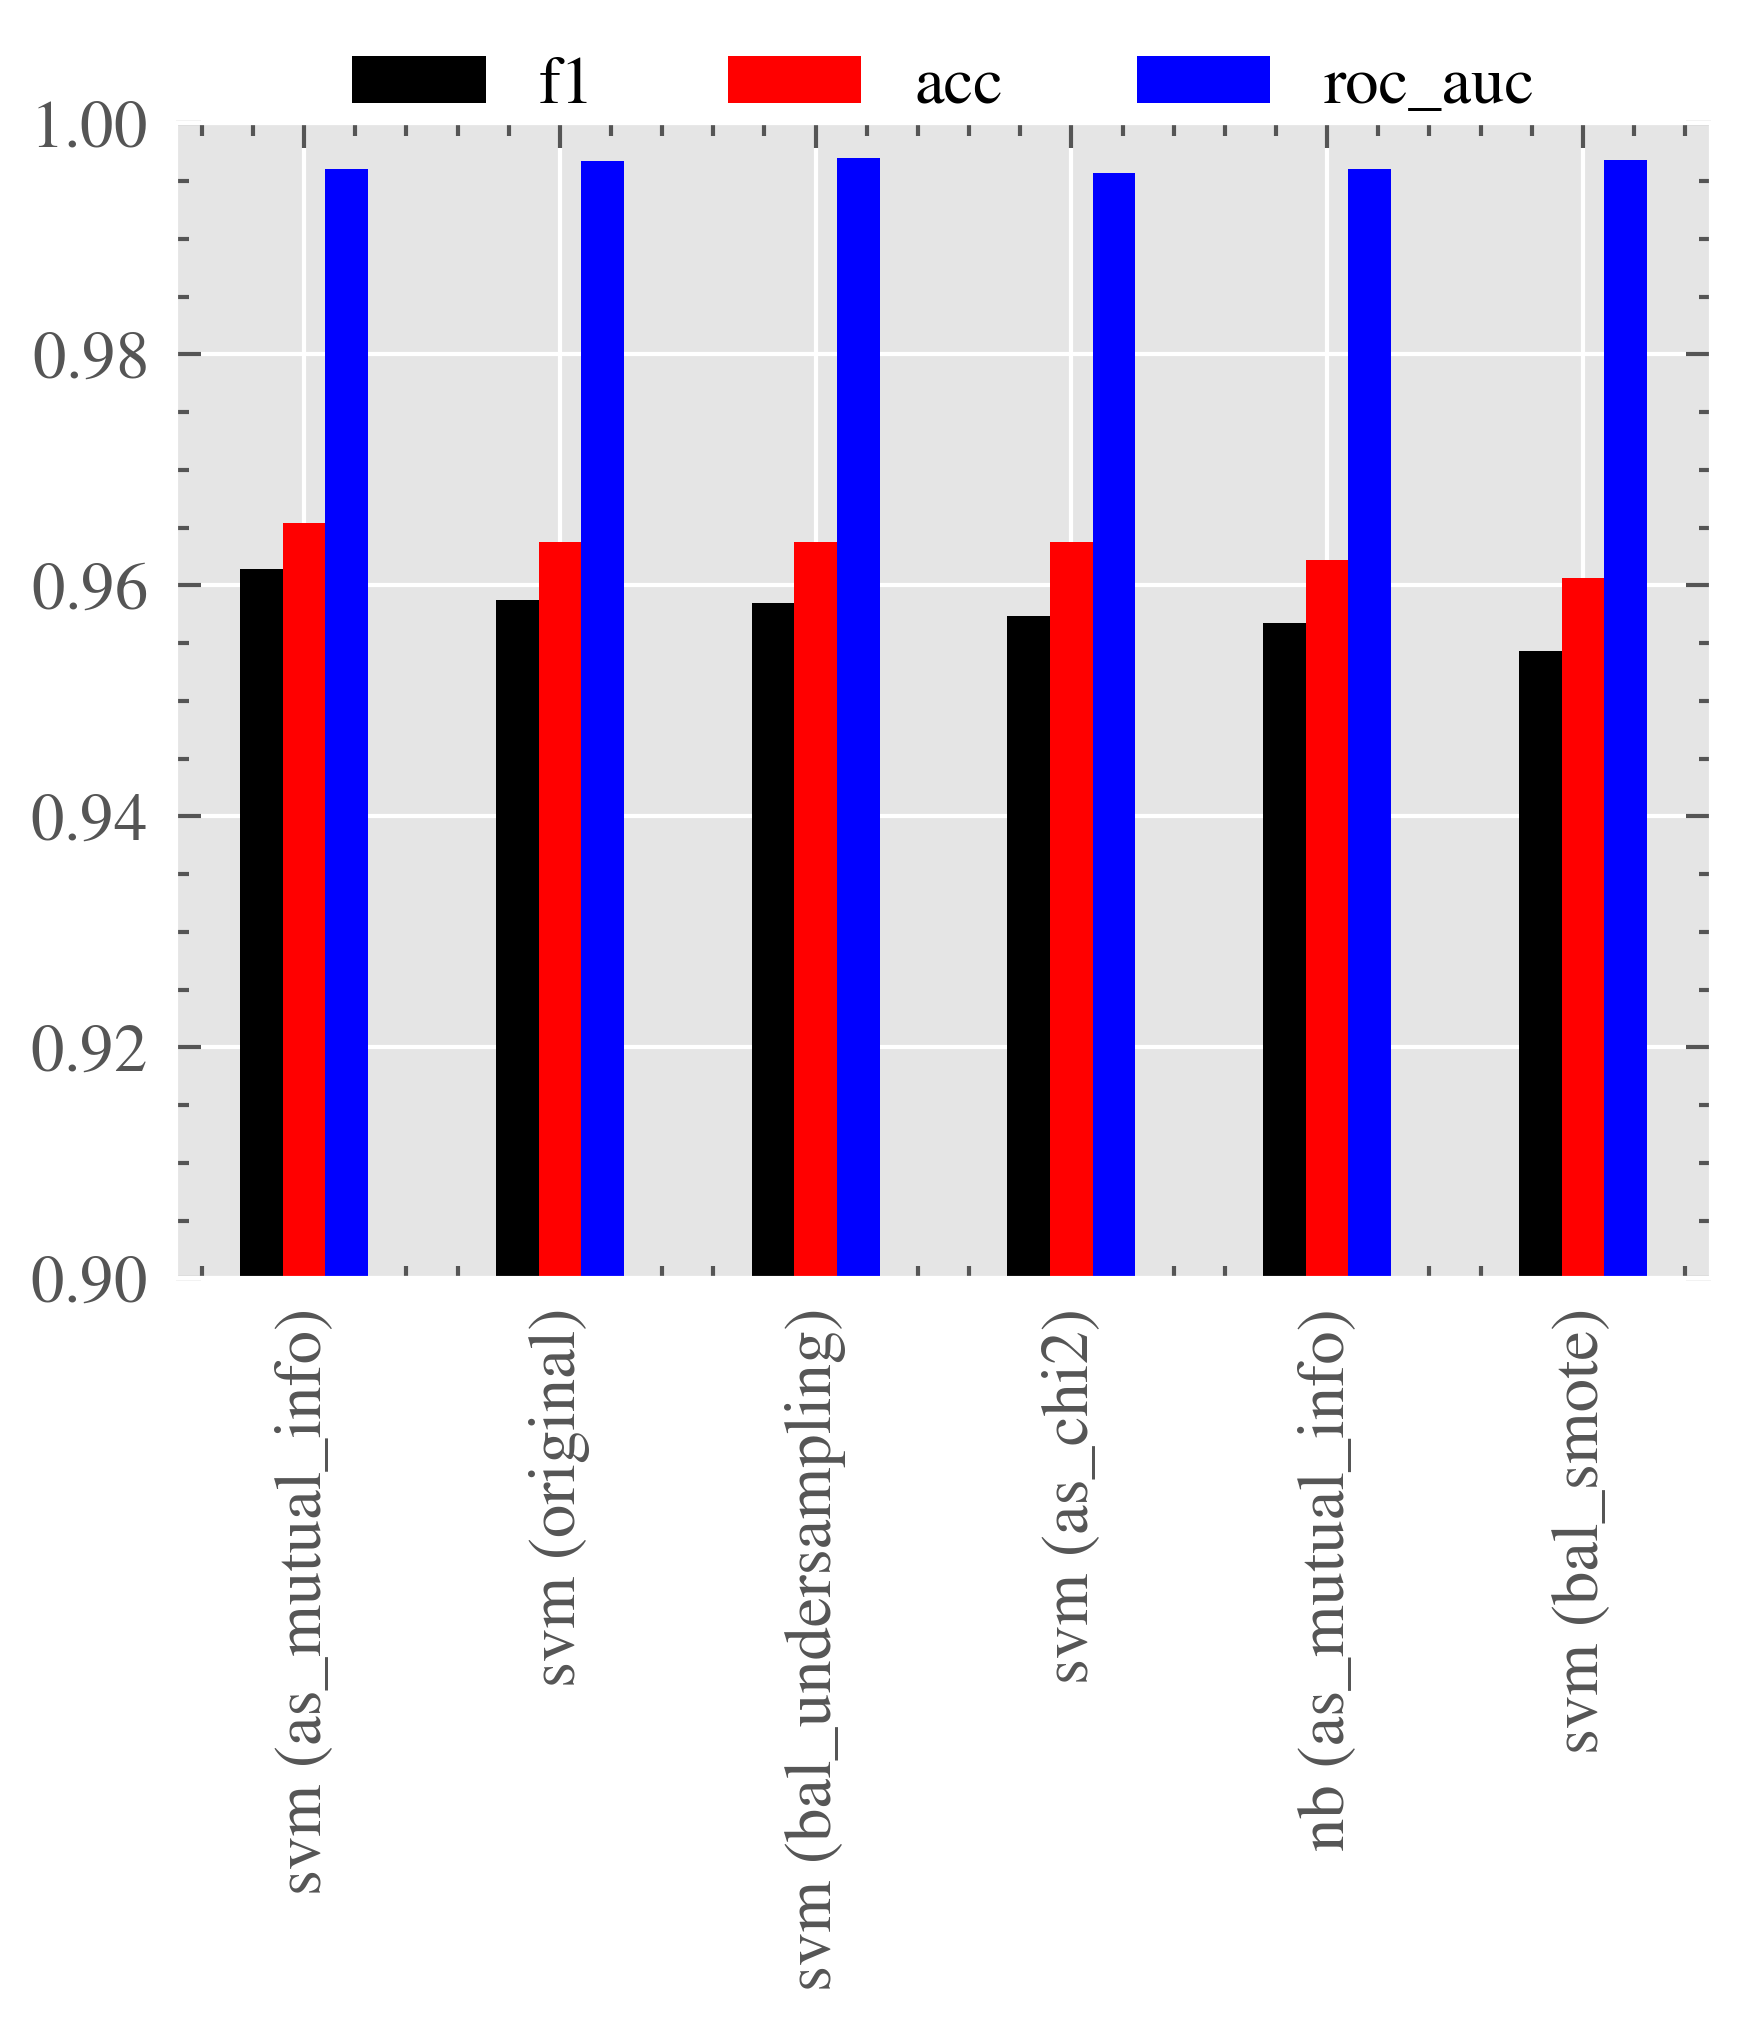

In [129]:
#métricas de validação (top 10 pares modelo-dataset)
top_n = 6
best_scored_models_test = test_metrics_df.nlargest(top_n, 'f1')
best_scored_models_test['est_dataset_name'] = best_scored_models_test['estimator_name'] + " (" + best_scored_models_test['dataset_name'] + ")"

best_scored_models_test.plot(kind='bar')#, figsize=(4,3))
plt.xticks(range(top_n), best_scored_models_test['est_dataset_name'])
plt.legend(loc='upper center', ncols=3, bbox_to_anchor=(0.5, 1.11))
plt.ylim([0.9, 1.0])
#plt.yscale('log')
plt.plot()

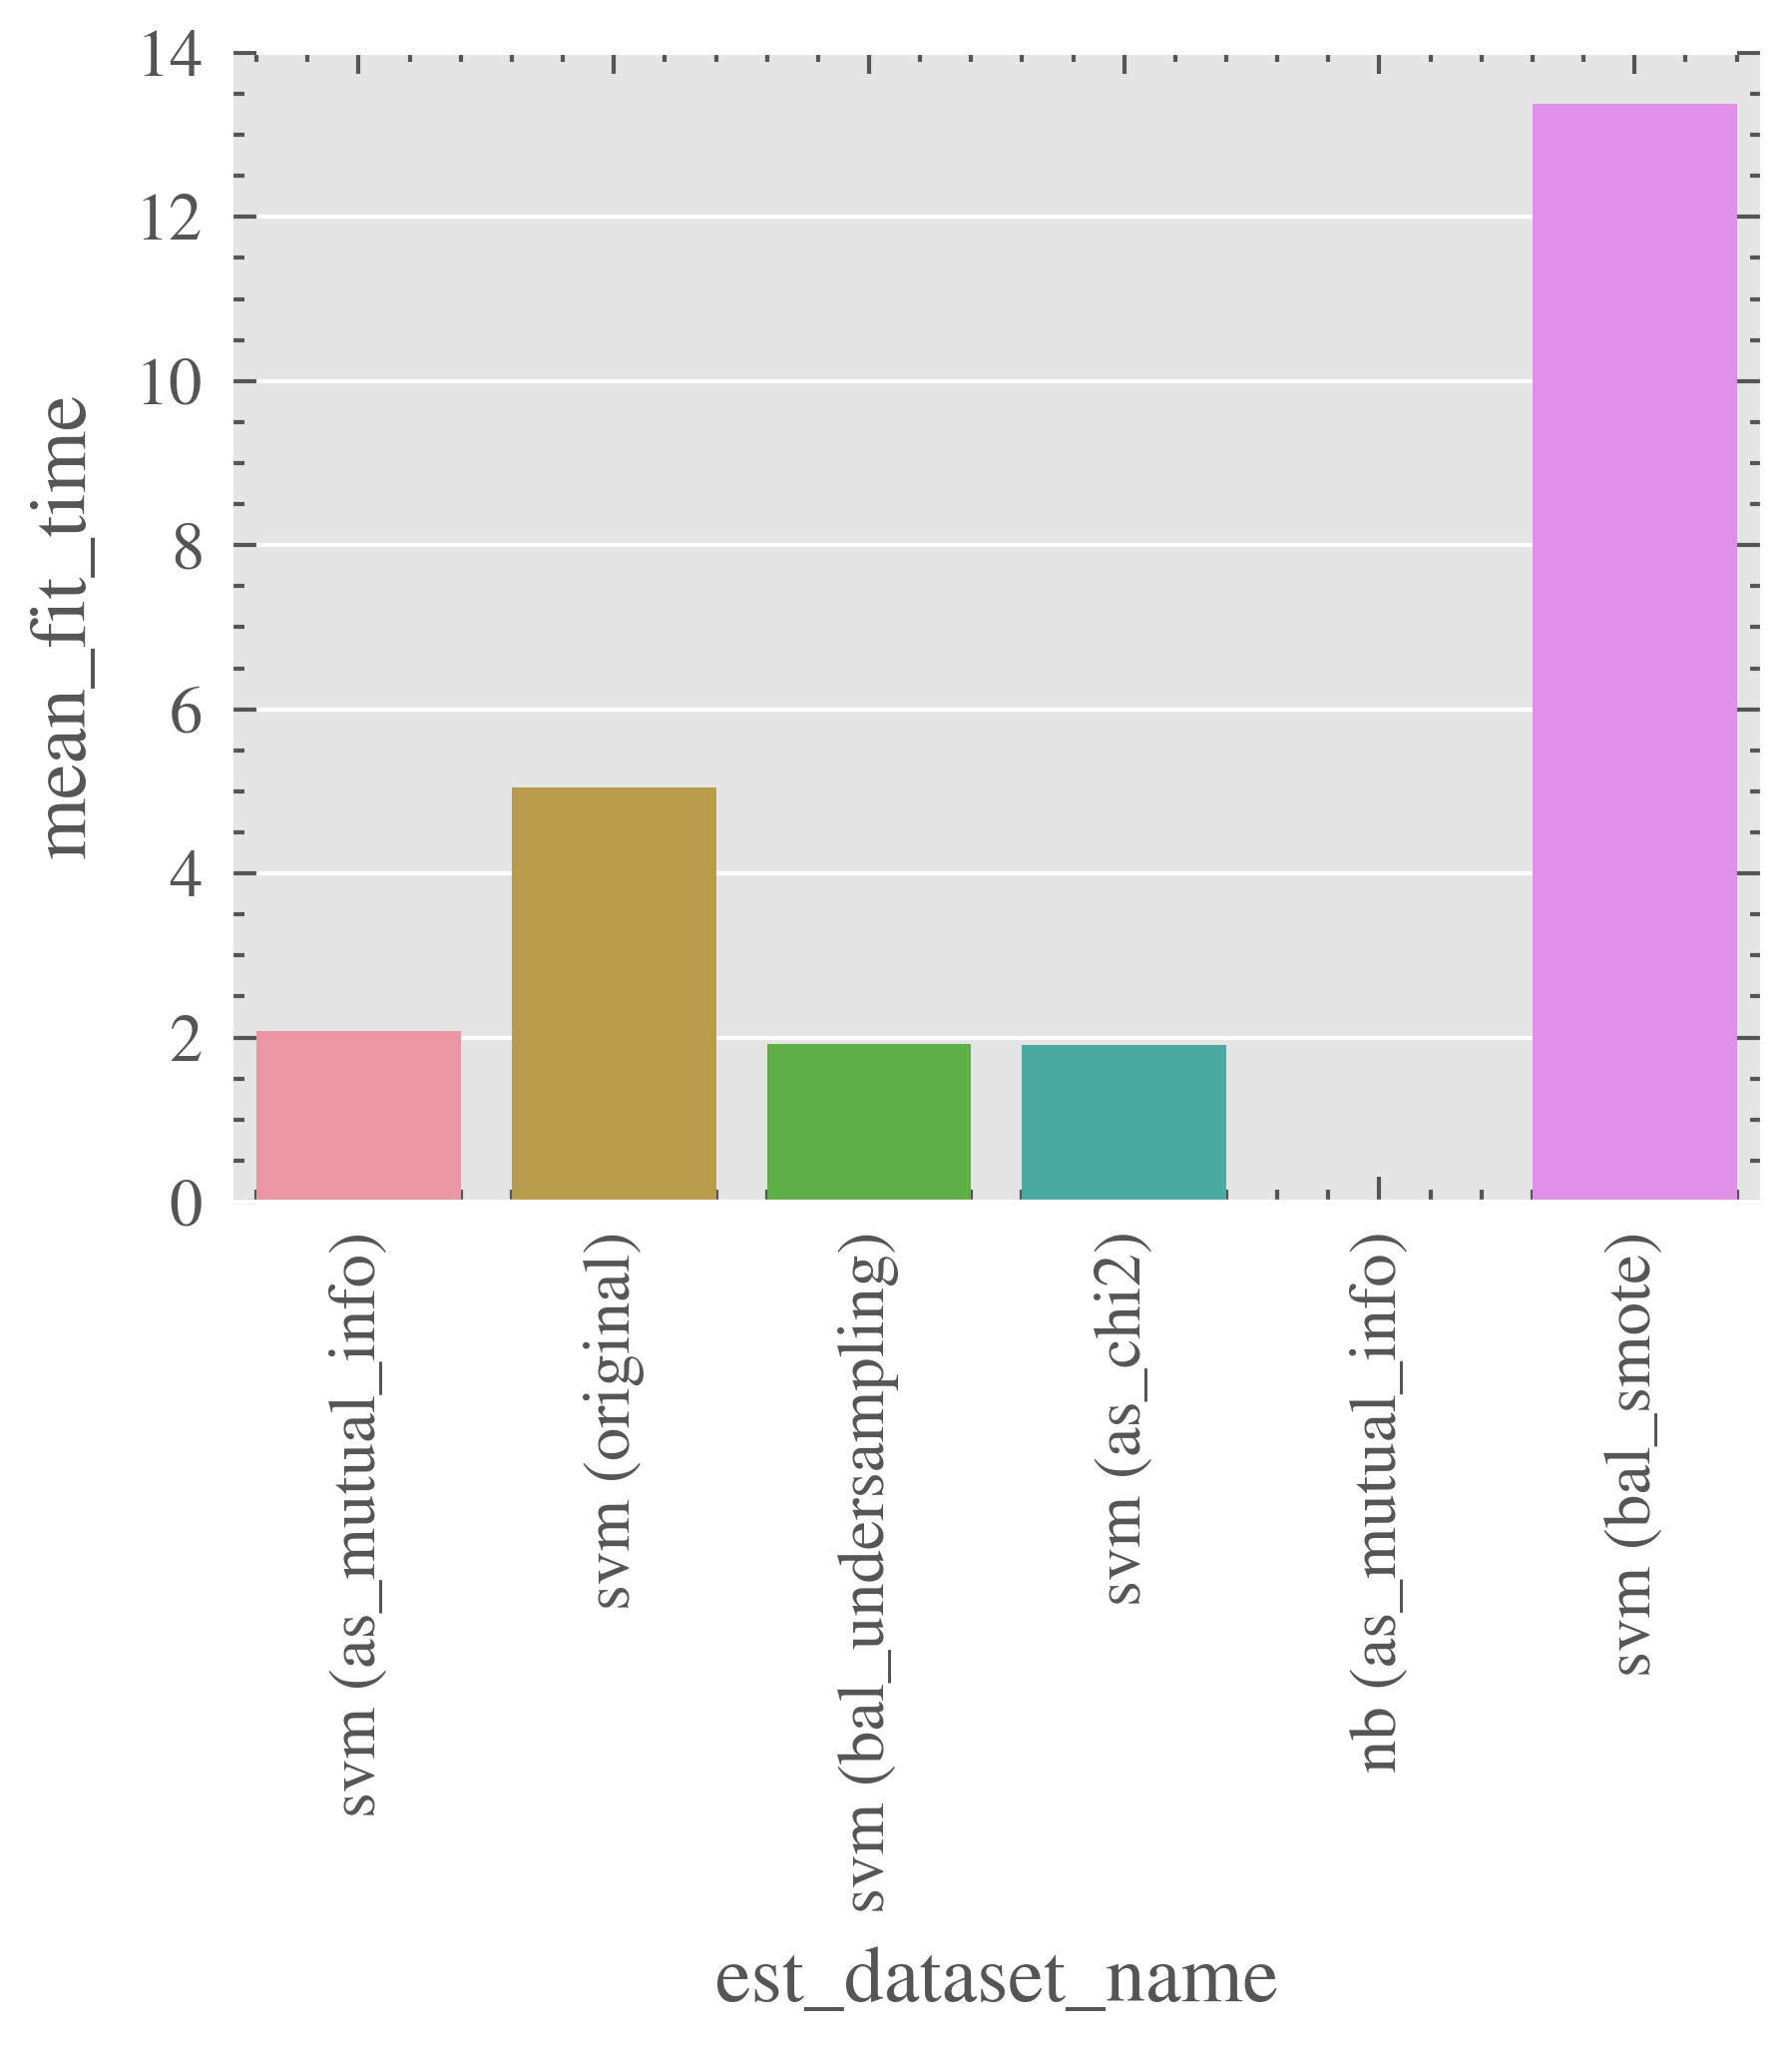

In [138]:
#Tempos médios para treinar os modelos acima

y_axis = train_metrics_df.iloc[best_scored_models_test.index, 0]
x_axis = best_scored_models_test['est_dataset_name']

sns.barplot(x=x_axis, y=y_axis)#, hue='estimator_name')
plt.xticks(rotation=90)
#plt.title("F1 Score x Accuracy (treino)")
plt.show()

Note que, entre os quatro melhores modelos (todos SVM), aqueles com pré-processamento chegam a levar menos da metade do tempo para treinarem.

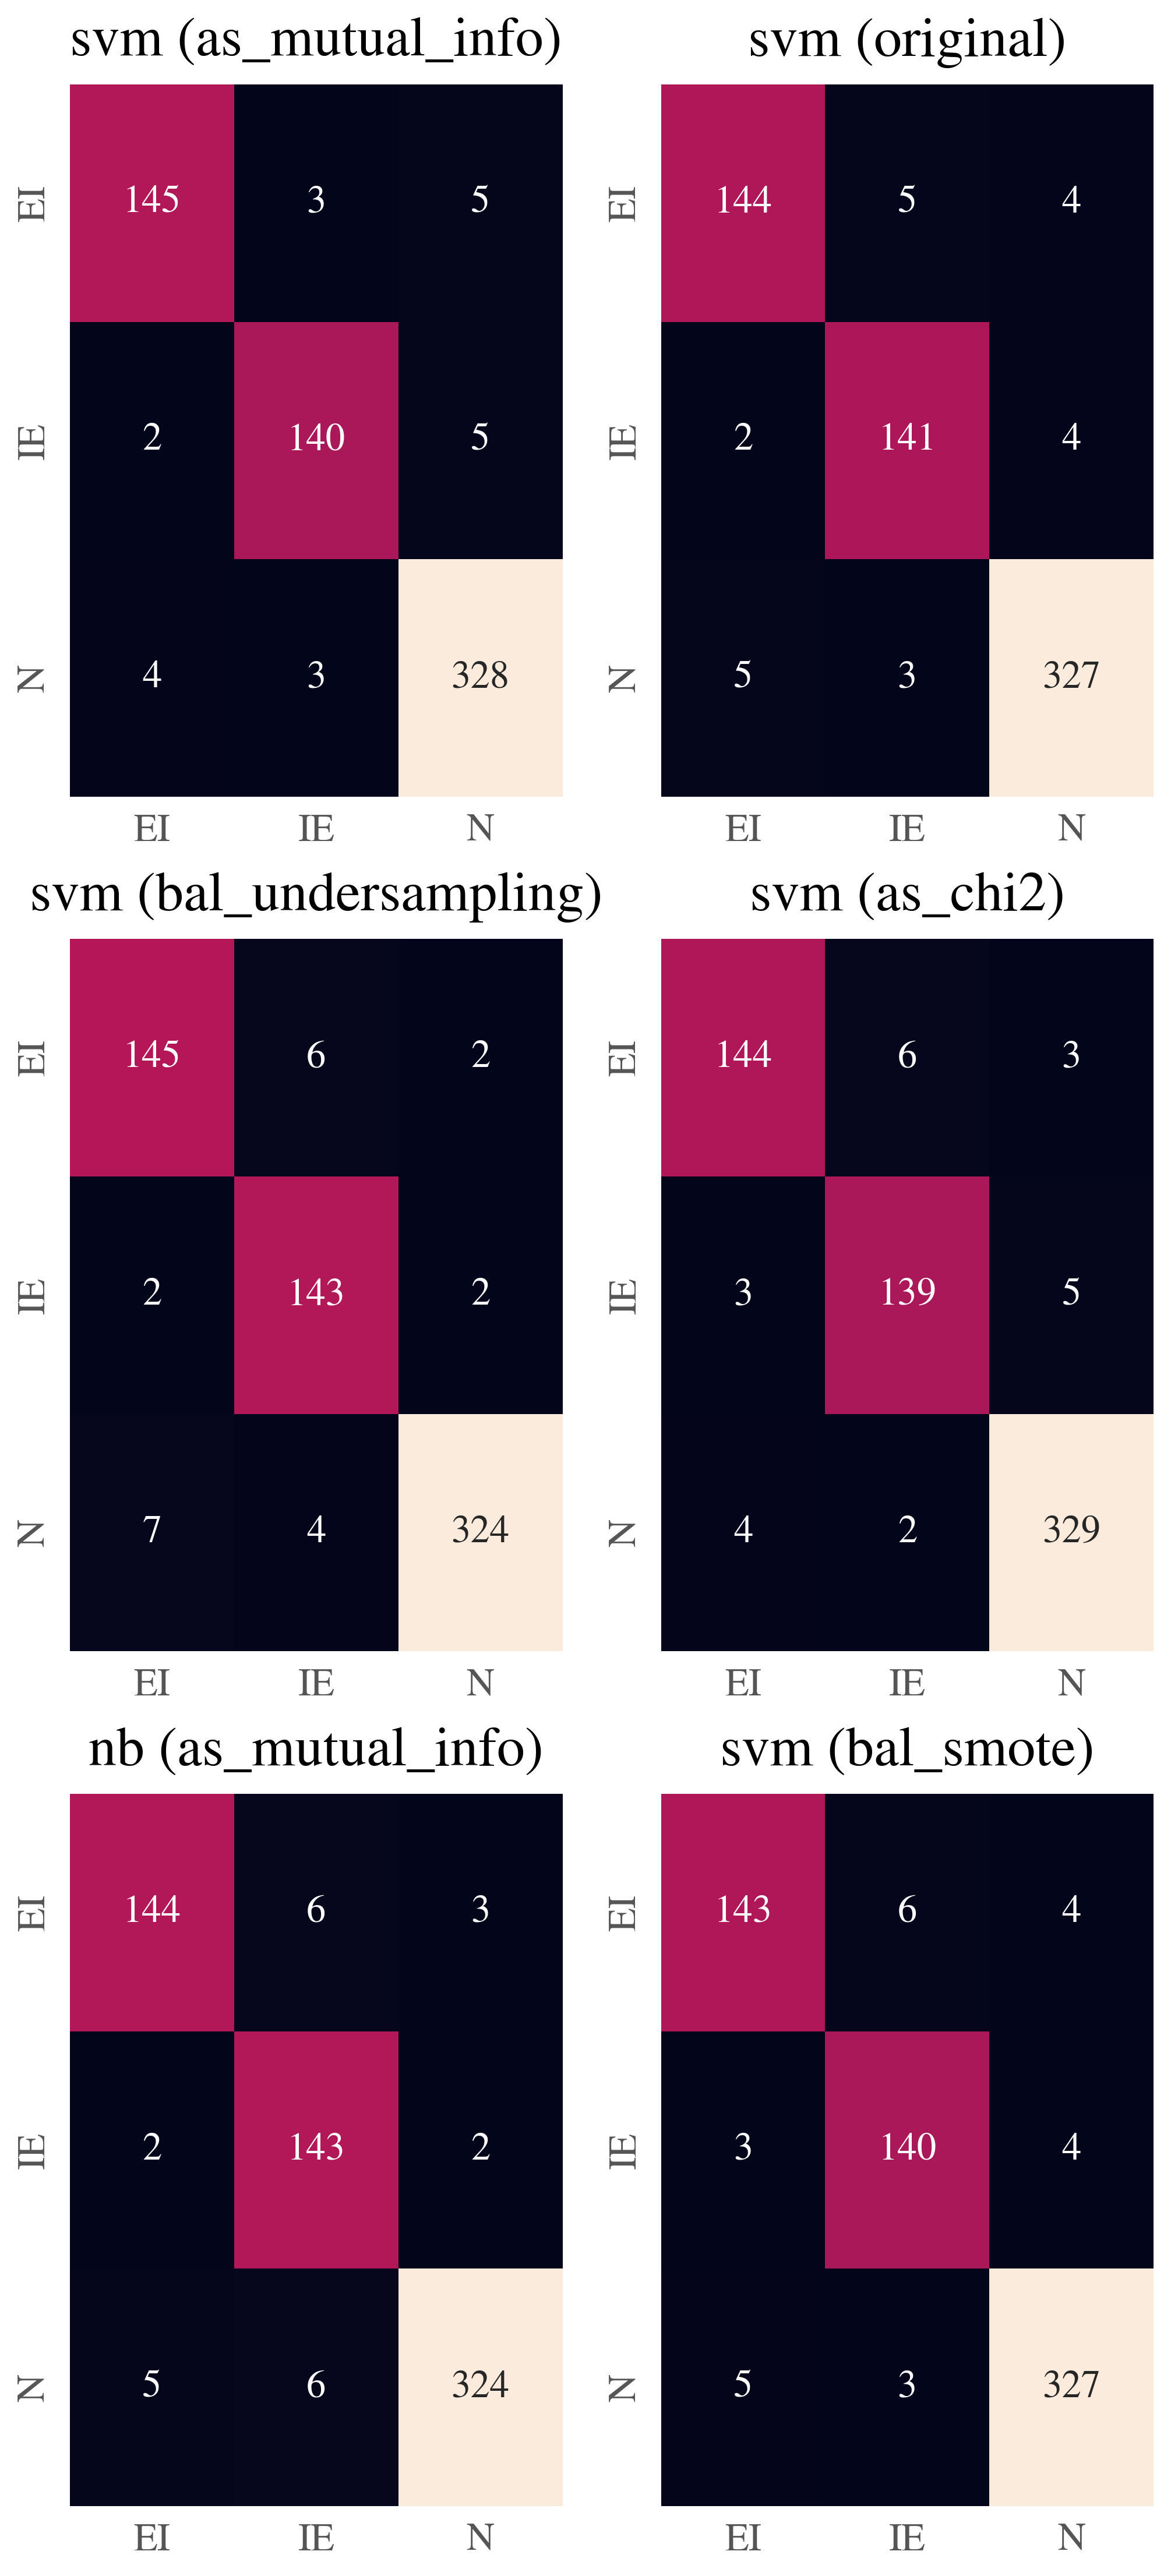

In [120]:
#TO DO: definir quantas confusion matrices colocaremos no artigo
#TO DO: corrigir isso aqui

labels = list(estimators.keys())
classes = ct.transformers_[1][1].categories_[0].tolist()
selected_conf_mats = np.array(conf_mats)[best_scored_models_test.index, :, :]


m = 3
n = 2
fig, ax = plt.subplots(m,n, figsize=(4,9))

k=0
for i, j in product(range(m), range(n)):
    sns.heatmap(selected_conf_mats[k, :, :], annot=True, fmt="", cbar=False, ax=ax[i, j])
    ax[i, j].set_xticklabels(classes)
    ax[i, j].set_yticklabels(classes)
    ax[i, j].set_title(best_scored_models_test['est_dataset_name'].iloc[k])
    k += 1